In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm

sns.set()

limit = 100

In [70]:
def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})


In [71]:
dick = pd.read_pickle('country_data.pkl')

us_state_dict = pd.read_pickle('us_state_dict.pkl')
ny = us_state_dict['New York']
ny.index = pd.DatetimeIndex(ny.index)
dick['New York'] = ny

ny.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 2020-03-10 to 2020-04-18
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   confirmed    40 non-null     float64
 1   deceased     40 non-null     float64
 2   recovered    40 non-null     float64
 3   inc          39 non-null     float64
 4   dead_inc     39 non-null     float64
 5   factor       39 non-null     float64
 6   dead_factor  35 non-null     float64
 7   density      40 non-null     float64
 8   population   40 non-null     int64  
 9   growth       40 non-null     float64
 10  gdp          40 non-null     int64  
 11  conf_per_M   40 non-null     float64
 12  dead_per_M   40 non-null     float64
dtypes: float64(11), int64(2)
memory usage: 4.4 KB


In [72]:
def process_country(country_name):
    df = dick[country_name]
    
    df = df[df['confirmed'] > limit]
    
    resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
    
    today = pd.datetime.today().weekday()

    yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]
    print (today)
    print (yesterday(today))
    
    #### MAKE SURE to adjust the param of resample so that all data points for the last week are included
    weekly = df[['inc','dead_inc']].resample(yesterday(today)).sum()
    weekly[['inc_per_M','dead_inc_per_M']] = weekly[['inc','dead_inc']] / (
        country_populations.loc[country_name,'population'] / 1e6)
    ####
    
    weekly['factor'] = weekly['inc'] / weekly['inc'].shift()
    weekly['dead_factor'] = weekly['dead_inc'] / weekly['dead_inc'].shift()
    
    print (weekly)
    
    return weekly
    

In [73]:
def plot(weekly,country_name):
    
    plt.figure(figsize=(18,12))
    
    plt.plot(weekly.index,weekly['inc'],'x--',color='orange',
            label=r'new confirmed')
    plt.plot(weekly.index,weekly['dead_inc'],'x--',color='crimson',
            label = 'new dead')
    
   
    
    plt.plot(weekly.index,weekly['factor'],'o-',color='orange',
            label=r'weekly growth factor confirmed [ last weekly growth factor: {:.2f} ]'.format(weekly['factor'][-1]))
    
    plt.plot(weekly.index,weekly['dead_factor'],'o-',color='crimson',
             label=r'weekly growth factor dead [ last weekly growth factor: {:.2f} ]'.format(weekly['dead_factor'][-1]))
    
    plt.title('Corona - weekly sum of new CONFIRMED and DEAD for {} [confirmed > {}]'.format(str.upper(country_name),limit))
    
    plt.plot(weekly.index, [1] * len(weekly.index),color='lime',ls = 'dashed',label='factor 1.00')
    
    y_max = weekly['inc'].max() * 10
    y_min = 0.1
    
    plt.ylim([y_min,y_max])
    plt.yscale('log')
    plt.ylabel('weekly total')  
    plt.xticks(rotation=90)
    plt.legend(loc='upper left')
    
    plt.savefig('corona_weekly_sums_{}.jpg'.format(country_name),format='jpg')


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


6
W-SAT
               inc  dead_inc   inc_per_M  dead_inc_per_M     factor  \
2020-03-07    67.0       0.0    6.634146        0.000000        NaN   
2020-03-14   800.0       2.0   79.213685        0.198034  11.940299   
2020-03-21   802.0      18.0   79.411720        1.782308   1.002500   
2020-03-28  1684.0      85.0  166.744808        8.416454   2.099751   
2020-04-04  2996.0     268.0  296.655252       26.536585   1.779097   
2020-04-11  3708.0     514.0  367.155432       50.894793   1.237650   
2020-04-18  3671.0     624.0  363.491799       61.786675   0.990022   

            dead_factor  
2020-03-07          NaN  
2020-03-14          inf  
2020-03-21     9.000000  
2020-03-28     4.722222  
2020-04-04     3.152941  
2020-04-11     1.917910  
2020-04-18     1.214008  
++++++++++++++++ SWEDEN ++++++++++++++
Sweden                inc  dead_inc   inc_per_M  dead_inc_per_M     factor  \
2020-03-07    67.0       0.0    6.634146        0.000000        NaN   
2020-03-14   800.0       2.

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


6
W-SAT
                inc  dead_inc    inc_per_M  dead_inc_per_M     factor  \
2020-03-07    416.0      10.0     8.897486        0.213882        NaN   
2020-03-14   5891.0     185.0   125.997818        3.956815  14.161058   
2020-03-21  18983.0    1180.0   406.011980       25.238062   3.222373   
2020-03-28  47861.0    4607.0  1023.660085       98.535384   2.521256   
2020-04-04  52933.0    5965.0  1132.140976      127.580544   1.105974   
2020-04-11  36859.0    4659.0   788.347236       99.647570   0.696333   
2020-04-18  28699.0    3437.0   613.819619       73.511203   0.778616   

            dead_factor  
2020-03-07          NaN  
2020-03-14    18.500000  
2020-03-21     6.378378  
2020-03-28     3.904237  
2020-04-04     1.294769  
2020-04-11     0.781056  
2020-04-18     0.737712  
++++++++++++++++ SPAIN ++++++++++++++
Spain                 inc  dead_inc    inc_per_M  dead_inc_per_M     factor  \
2020-03-07    416.0      10.0     8.897486        0.213882        NaN   
2020-03-1

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


6
W-SAT
                inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-02-29   1066.0      27.0   17.630959        0.446563       NaN   
2020-03-07   4755.0     204.0   78.644664        3.374030  4.460600   
2020-03-14  15274.0    1208.0  252.622208       19.979549  3.212198   
2020-03-21  32421.0    3384.0  536.222641       55.969199  2.122627   
2020-03-28  38894.0    5198.0  643.281928       85.971601  1.199655   
2020-04-04  32160.0    5339.0  531.905867       88.303651  0.826863   
2020-04-11  27639.0    4106.0  457.131414       67.910619  0.859422   
2020-04-18  23654.0    3759.0  391.222058       62.171460  0.855820   

            dead_factor  
2020-02-29          NaN  
2020-03-07     7.555556  
2020-03-14     5.921569  
2020-03-21     2.801325  
2020-03-28     1.536052  
2020-04-04     1.027126  
2020-04-11     0.769058  
2020-04-18     0.915490  
++++++++++++++++ ITALY ++++++++++++++
Italy                 inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
202

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


6
W-SAT
                 inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-03-07     304.0      11.0    0.918422        0.033232       NaN   
2020-03-14    2325.0      37.0    7.024113        0.111782  7.648026   
2020-03-21   22873.0     253.0   69.102166        0.764344  9.837849   
2020-03-28   95865.0    1719.0  289.620037        5.193312  4.191186   
2020-04-04  187388.0    6381.0  566.122354       19.277791  1.954707   
2020-04-11  217543.0   12055.0  657.224343       36.419648  1.160923   
2020-04-18  205801.0   18202.0  621.750307       54.990496  0.946024   

            dead_factor  
2020-03-07          NaN  
2020-03-14     3.363636  
2020-03-21     6.837838  
2020-03-28     6.794466  
2020-04-04     3.712042  
2020-04-11     1.889202  
2020-04-18     1.509913  
++++++++++++++++ US ++++++++++++++
US                  inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-03-07     304.0      11.0    0.918422        0.033232       NaN   
2020-03-14    2325.0     

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


6
W-SAT
                inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-03-07    720.0       0.0    8.593532        0.000000       NaN   
2020-03-14   3786.0       9.0   45.187657        0.107419  5.258333   
2020-03-21  17628.0      75.0  210.398312        0.895160  4.656101   
2020-03-28  35482.0     349.0  423.494039        4.165476  2.012821   
2020-04-04  38397.0    1011.0  458.285909       12.066751  1.082154   
2020-04-11  28816.0    1292.0  343.932254       15.420616  0.750475   
2020-04-18  18434.0    1723.0  220.018294       20.564800  0.639714   

            dead_factor  
2020-03-07          NaN  
2020-03-14          inf  
2020-03-21     8.333333  
2020-03-28     4.653333  
2020-04-04     2.896848  
2020-04-11     1.277943  
2020-04-18     1.333591  
++++++++++++++++ GERMANY ++++++++++++++
Germany                 inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-03-07    720.0       0.0    8.593532        0.000000       NaN   
2020-03-14   3786.0      

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


6
W-SAT
               inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-03-07   106.0       1.0    6.186215        0.058361       NaN   
2020-03-14   774.0      11.0   45.171041        0.641966  7.301887   
2020-03-21  2678.0     125.0  156.289466        7.295065  3.459948   
2020-03-28  6179.0     503.0  360.609639       29.355340  2.307319   
2020-04-04  6908.0    1016.0  403.154456       59.294286  1.117980   
2020-04-11  7844.0     997.0  457.779901       58.185436  1.135495   
2020-04-18  7195.0     960.0  419.903925       56.026097  0.917262   

            dead_factor  
2020-03-07          NaN  
2020-03-14    11.000000  
2020-03-21    11.363636  
2020-03-28     4.024000  
2020-04-04     2.019881  
2020-04-11     0.981299  
2020-04-18     0.962889  
++++++++++++++++ NETHERLANDS ++++++++++++++
Netherlands                inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-03-07   106.0       1.0    6.186215        0.058361       NaN   
2020-03-14   774.0      11.

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


6
W-SAT
               inc  dead_inc   inc_per_M  dead_inc_per_M     factor  \
2020-03-07    67.0       0.0    6.634146        0.000000        NaN   
2020-03-14   800.0       2.0   79.213685        0.198034  11.940299   
2020-03-21   802.0      18.0   79.411720        1.782308   1.002500   
2020-03-28  1684.0      85.0  166.744808        8.416454   2.099751   
2020-04-04  2996.0     268.0  296.655252       26.536585   1.779097   
2020-04-11  3708.0     514.0  367.155432       50.894793   1.237650   
2020-04-18  3671.0     624.0  363.491799       61.786675   0.990022   

            dead_factor  
2020-03-07          NaN  
2020-03-14          inf  
2020-03-21     9.000000  
2020-03-28     4.722222  
2020-04-04     3.152941  
2020-04-11     1.917910  
2020-04-18     1.214008  
6
W-SAT
                inc  dead_inc    inc_per_M  dead_inc_per_M     factor  \
2020-03-07    416.0      10.0     8.897486        0.213882        NaN   
2020-03-14   5891.0     185.0   125.997818        3.956815  1

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


6
W-SAT
                inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-03-07    720.0       0.0    8.593532        0.000000       NaN   
2020-03-14   3786.0       9.0   45.187657        0.107419  5.258333   
2020-03-21  17628.0      75.0  210.398312        0.895160  4.656101   
2020-03-28  35482.0     349.0  423.494039        4.165476  2.012821   
2020-04-04  38397.0    1011.0  458.285909       12.066751  1.082154   
2020-04-11  28816.0    1292.0  343.932254       15.420616  0.750475   
2020-04-18  18434.0    1723.0  220.018294       20.564800  0.639714   

            dead_factor  
2020-03-07          NaN  
2020-03-14          inf  
2020-03-21     8.333333  
2020-03-28     4.653333  
2020-04-04     2.896848  
2020-04-11     1.277943  
2020-04-18     1.333591  
6
W-SAT
               inc  dead_inc   inc_per_M  dead_inc_per_M    factor  \
2020-03-07   106.0       1.0    6.186215        0.058361       NaN   
2020-03-14   774.0      11.0   45.171041        0.641966  7.301887 

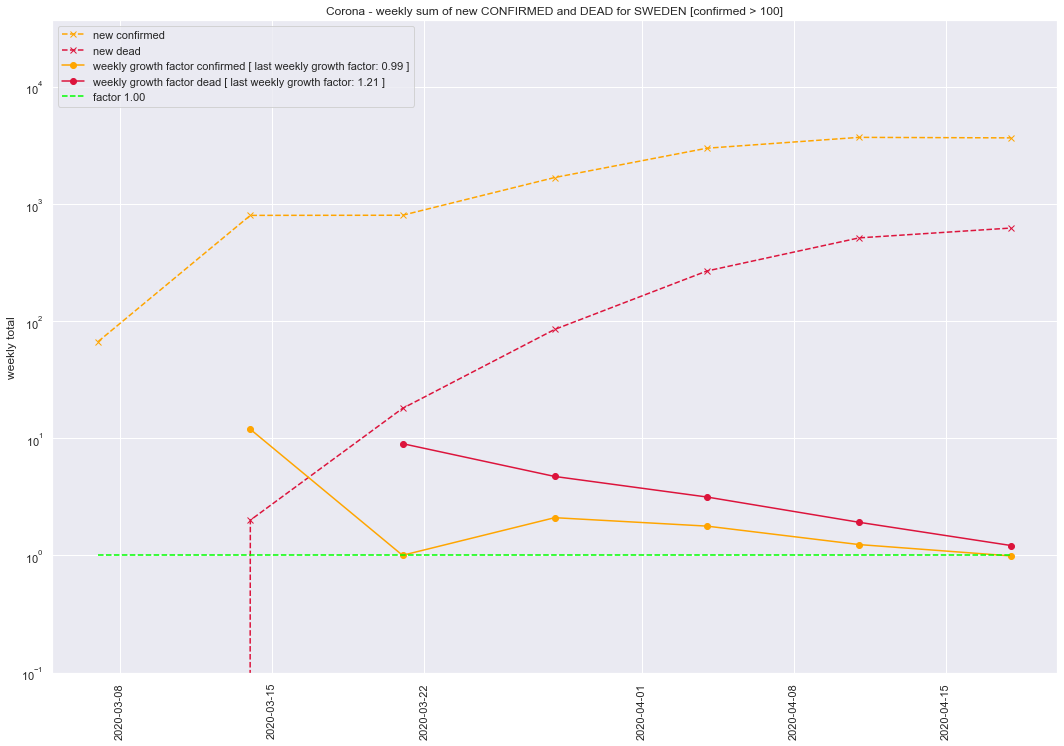

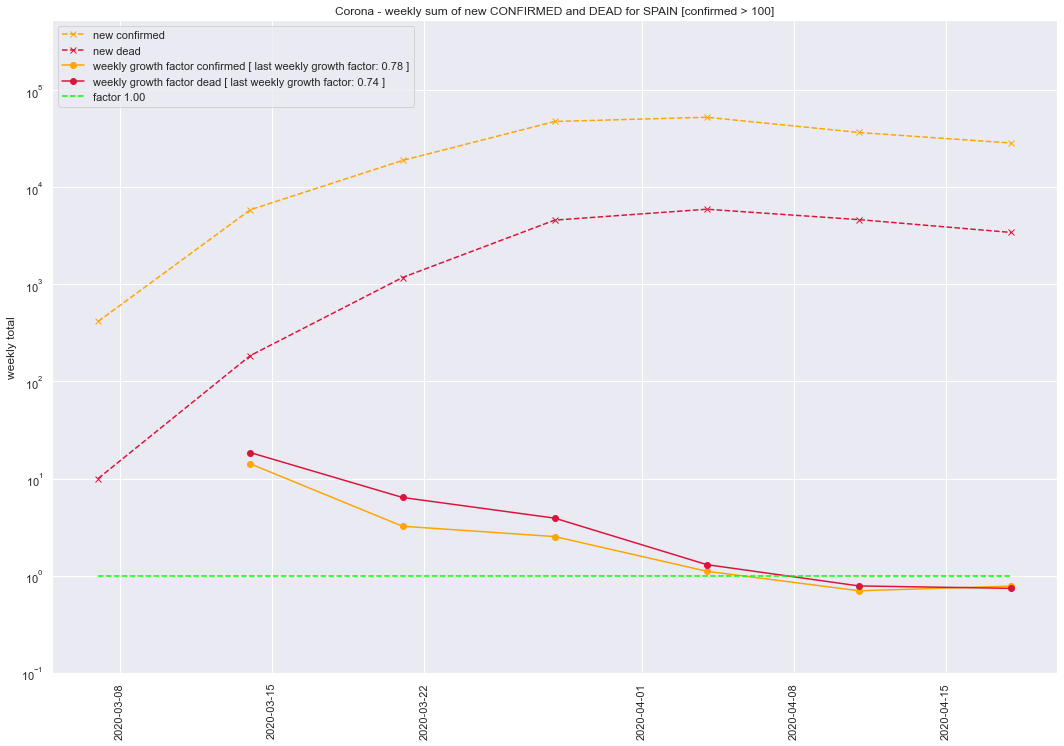

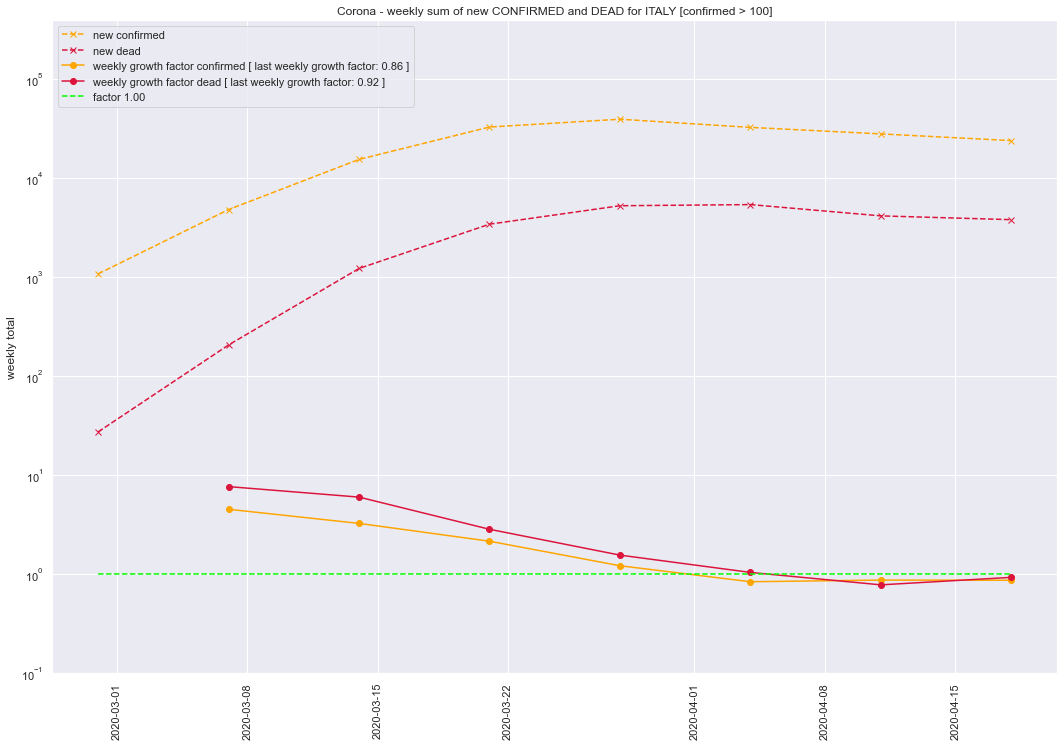

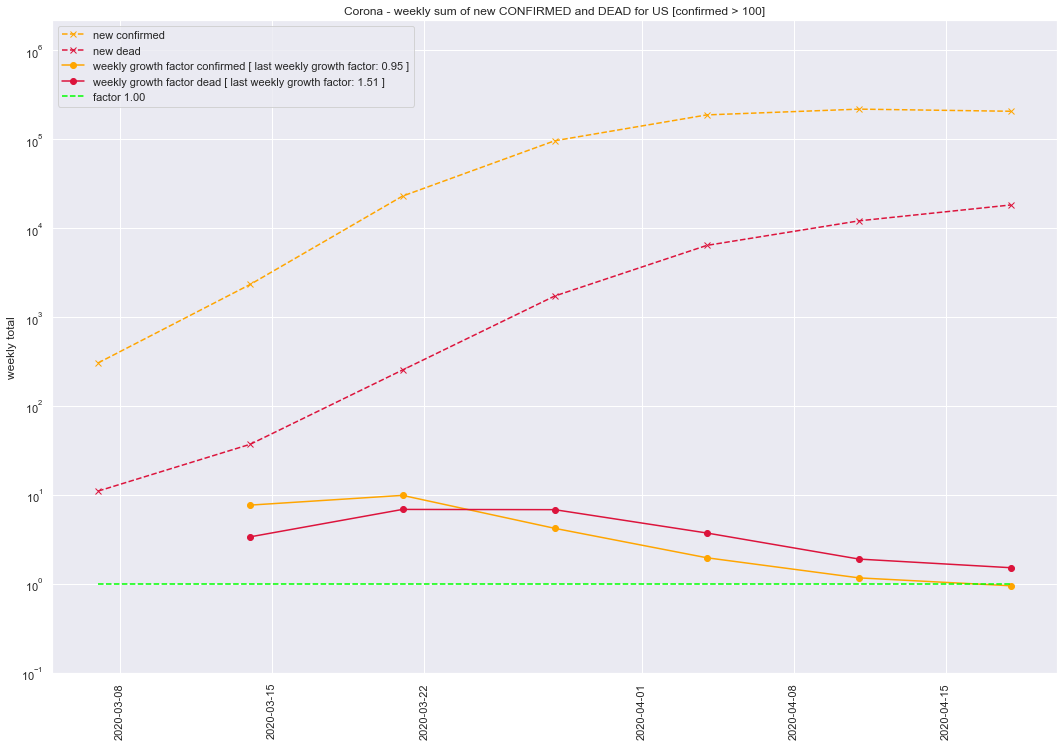

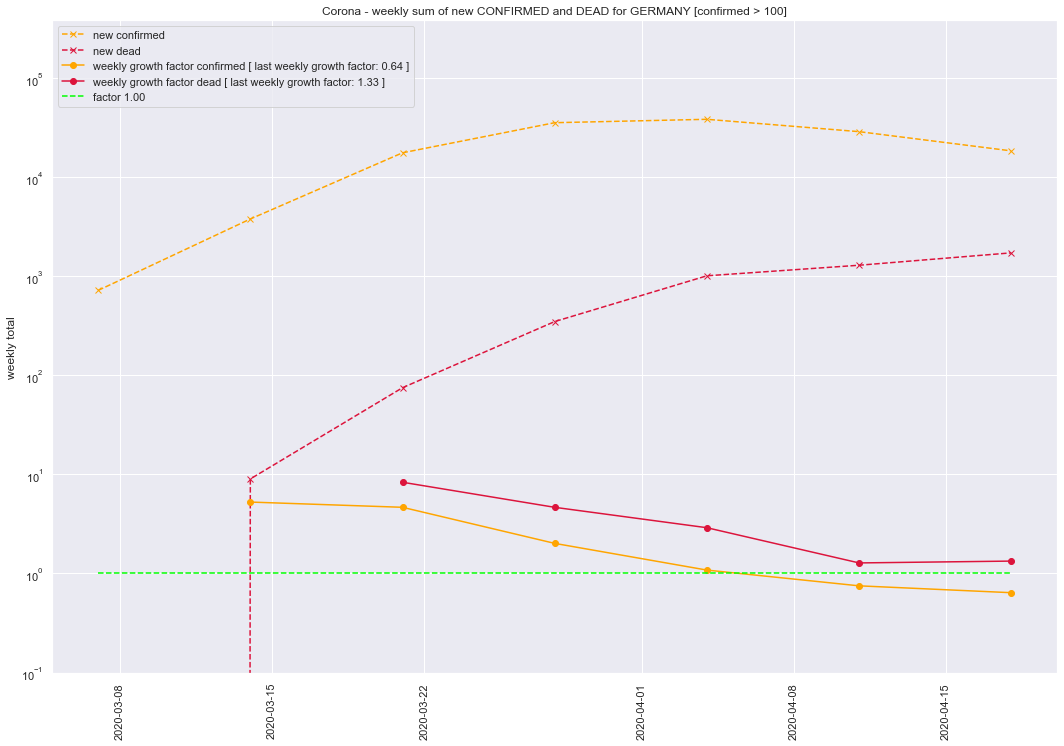

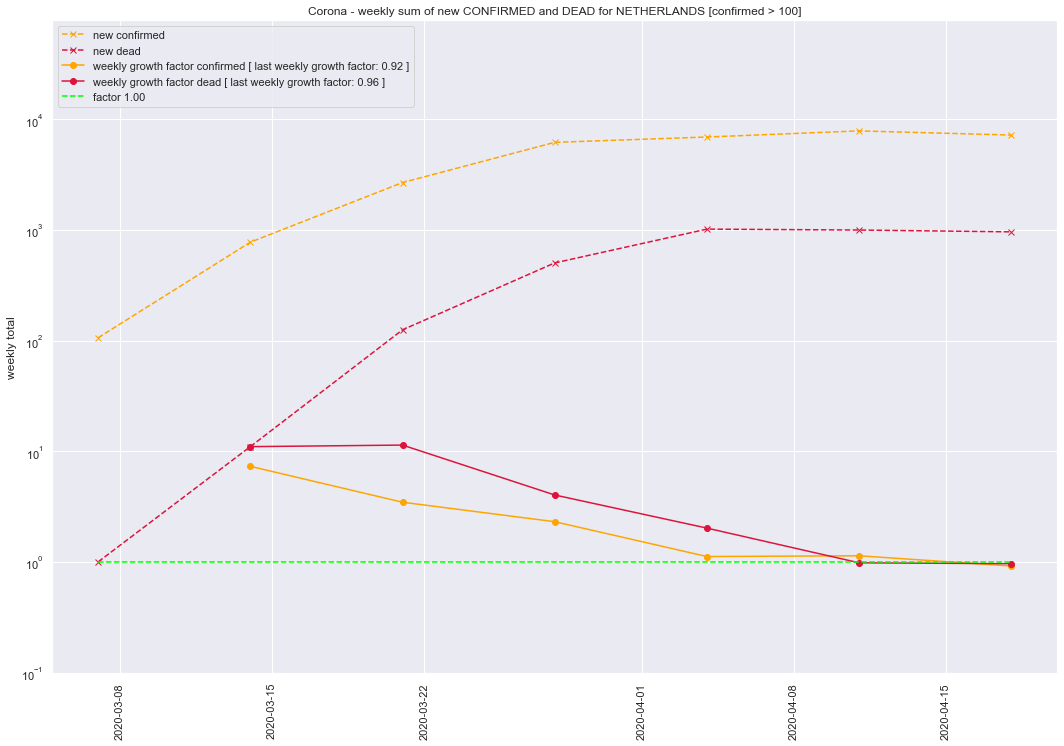

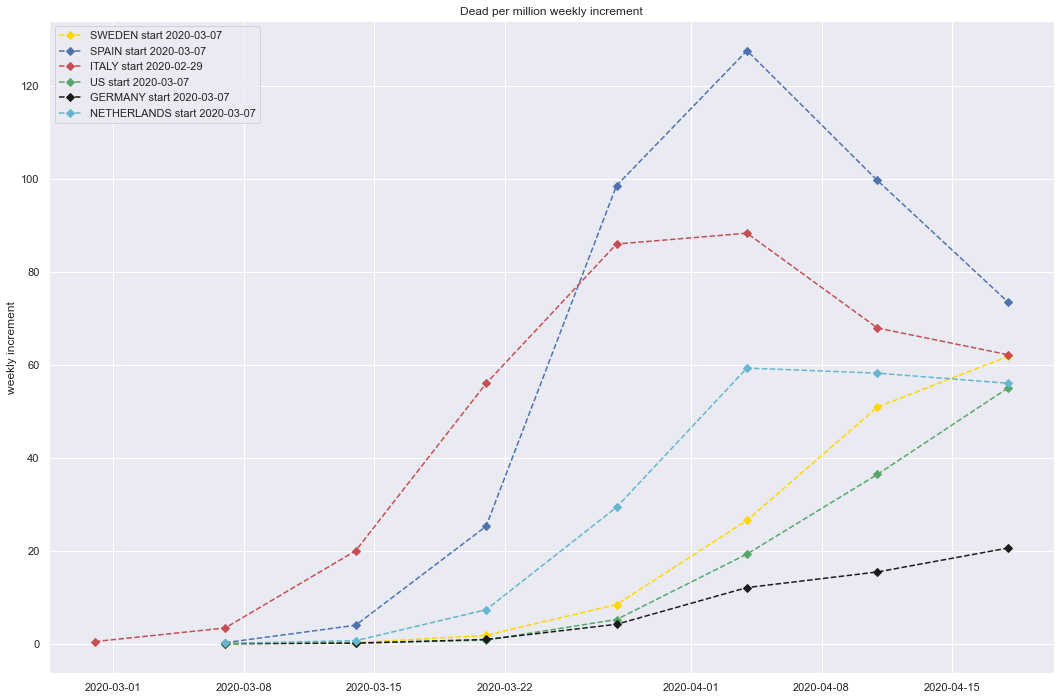

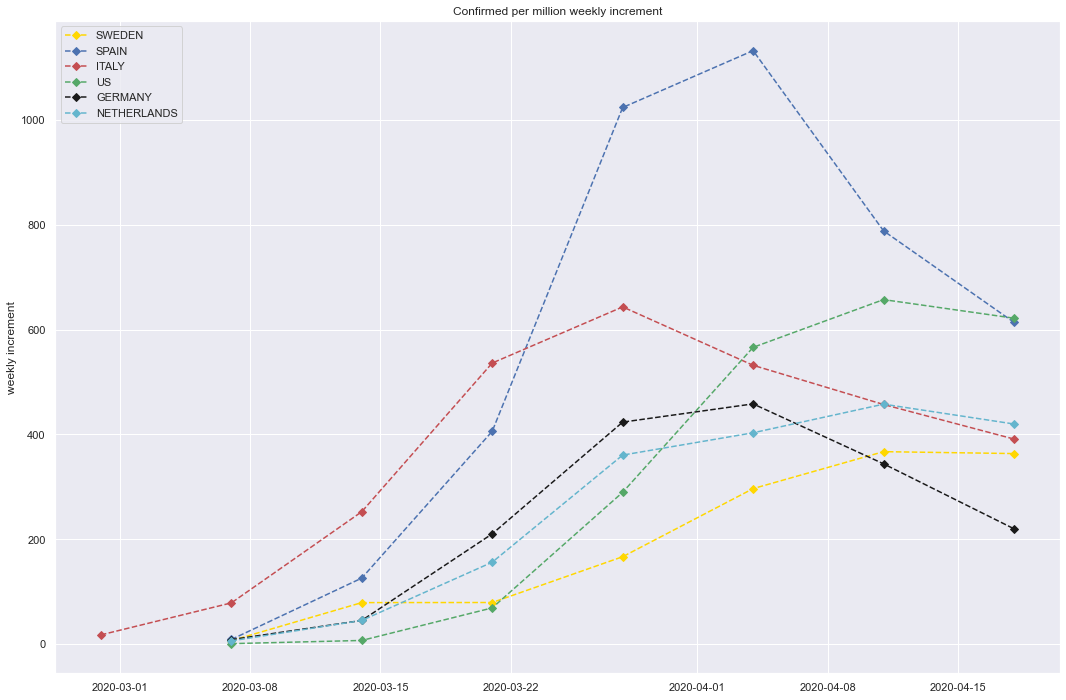

In [74]:
countries = ['Sweden','Spain','Italy','US','Germany','Netherlands']
colors = ['gold','b','r','g','k','c','lime']
#countries = ['Sweden']

fignr = 1

for c in countries:
    weekly = process_country(c)
    print ('++++++++++++++++ {} ++++++++++++++'.format(str.upper(c)))
    print (c,weekly.tail(10))
    plot(weekly,c)
    fignr += 1
    


# plot all normalized on same plot

plt.figure(fignr + 1,figsize=(18,12))
plt.figure(fignr + 2,figsize=(18,12))

for i,c in enumerate(countries):
    plt.figure(fignr +1 )
    plt.title('Dead per million weekly increment')
    weekly = process_country(c)
    
    plt.plot(weekly.index,weekly['dead_inc_per_M'],'D--',
             color=colors[i],label=c.upper() + ' start ' + str(weekly.index[0].date()))
    
    #plt.yscale('log') # NOTICE that log scale makes the growth look much smaller...!!!
    
    plt.legend(loc='upper left')
    plt.ylabel('weekly increment')
    plt.figure(fignr + 2)
    plt.title('Confirmed per million weekly increment')
    plt.plot(weekly.index,weekly['inc_per_M'],'D--',color=colors[i],label=c.upper())
    plt.legend(loc='upper left')
    plt.ylabel('weekly increment')

plt.figure(fignr +1)
plt.savefig('weekly__dead_consolidated_sums_per_million.jpg')
plt.figure(fignr +2)
plt.savefig('weekly_conf_consolidated_sums_per_million.jpg')